# Assigment 5
# Tracking of a moving object which trajectory is disturbed by random acceleration 

## Team 6: Berman Vladimir, Dronova Maria, Bazhenov Artem, Skoltech, October, 2022

### Initialisation of libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Setting functions

In [2]:
# generating velocity vi and acceleration ai
def gnerate_vel_and_ac(exp, var, T, V0, numb):
    arr = np.zeros(numb)
    a = np.random.normal(exp, var ** 0.5, numb)
    arr[0] = V0
    for i in range(1, len(arr)):
        arr[i] = arr[i - 1] + a[i - 1] * T
    return arr, a

# generating coordinate xi 
def generate_x(T, X0, a, v):
    arr = np.zeros(len(a))
    arr[0] = X0
    for i in range(1, len(a)):
        arr[i] = arr[i - 1] + v[i - 1] * T + a[i - 1] * (T ** 2) / 2
    return arr

# Kalman filter
def kalman_filt(z, X0, P0, F, Q, R, H):
    arr = np.zeros([200, 2])
    P = np.zeros([200, 2 , 2])
    K = np.zeros([200, 2])
    arr[0] = X0
    P[0] = P0
    for i in range(1, len(X)):
        arr[i] = np.dot(F, arr[i - 1].reshape(2, 1)).reshape(1, 2)
        P[i] = np.dot(np.dot(F, P[i - 1]), F.transpose()) + Q

        K[i] = (P[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(P[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)

        arr[i] = arr[i] + K[i] * (z[i] - np.dot(H, arr[i]))
        P[i] = (np.identity(2) - (K[i].reshape(2,1)).dot(H.reshape(1,2))).dot(P[i])
        
    return arr, P, K, P[len(P) - 1], K[len(K) - 1]

# Kalman filter with fixed K
def kalman_filt_fix_K(z, X0, P0, F, Q, R, H, K_fix):
    arr = np.zeros([200, 2])
    P = np.zeros([200, 2 , 2])
    K = np.zeros([200, 2])
    arr[0] = X0
    P[0] = P0
    for i in range(1, len(X)):
        arr[i] = np.dot(F, arr[i - 1].reshape(2, 1)).reshape(1, 2)
        P[i] = np.dot(np.dot(F, P[i - 1]), F.transpose()) + Q

        K[i] = K_fix
        arr[i] = arr[i] + K[i] * (z[i] - np.dot(H, arr[i]))
        P[i] = (np.identity(2) - (K[i].reshape(2,1)).dot(H.reshape(1,2))).dot(P[i])
        
    return arr, P, K, P[len(P) - 1], K[len(K) - 1]

# extrapolation
def extrapol(x, m, F):
    arr = np.array(x)
    F_pow = np.linalg.matrix_power(F, m - 1)
    for i in range(len(x) - m + 1):
        arr[i + m - 1] = F_pow.dot(x[i])
    return arr  

### 1. Generating a true trajectory Xi of an object motion disturbed by normally distributed random acceleration

In [3]:
x0 = 5
v0 = 1
T = 1
sigmaa_2 = 0.2 ** 2
numb = 200

v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a, v)

v1,a1 = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x1 = generate_x(T, x0, a1, v1)

v2,a2 = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x2 = generate_x(T, x0, a2, v2)

### 2. Generating measurements zi of the coordinate xi 

In [4]:
sigmaeta_2 = 20 ** 2
eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
z = x + eta

### 3. ConstructIing Kalman filter 

#### Setting transition matrix F, input matrix G, observation matix H

In [5]:
F = np.array([[1, T], [0, 1]])
G = np.array([T ** 2 / 2, T])
H = np.array([1, 0])

#### Generating state vector

In [6]:
X = np.zeros([200, 2])
X[0] = np.array([x[0], v[0]])
for i in range(1, len(X)):
    X[i] = np.dot(F, X[i - 1]) + np.dot(G, a[i - 1])
    
X1 = np.zeros([200, 2])
X1[0] = np.array([x[0], v[0]])
for i in range(1, len(X1)):
    X1[i] = np.dot(F, X1[i - 1]) + np.dot(G, a1[i - 1])
    
X2 = np.zeros([200, 2])
X2[0] = np.array([x[0], v[0]])
for i in range(1, len(X2)):
    X2[i] = np.dot(F, X2[i - 1]) + np.dot(G, a2[i - 1])

#### Generating measurements

In [7]:
z1 = np.zeros(200)
z2 = np.zeros(200)
for i in range(len(x)):
    z[i] = np.dot(H, X[i]) + eta[i]
    
for i in range(len(x)):
    z1[i] = np.dot(H, X1[i]) + eta[i]
    
for i in range(len(x)):
    z2[i] = np.dot(H, X2[i]) + eta[i]

### 4. Developing Kalman filter algorithm

In [8]:
Q = np.dot(np.dot(G, G.transpose()), sigmaa_2) # covariance matrix Q of state noise Ga
R = sigmaeta_2 # covariance matrix R of measurements noise eta
X0 = np.array([2, 0]) # initial filtered estimate 
P0 = np.array([[10000, 0], [0, 10000]]) # initial filtration error covariance matrix 

X_filt, P, K = kalman_filt(z, X0, P0, F, Q, R, H)[:3]

X1_filt, P, K = kalman_filt(z1, X0, P0, F, Q, R, H)[:3]
X2_filt, P, K = kalman_filt(z2, X0, P0, F, Q, R, H)[:3]

### 5. Plotting results

Text(0.5, 1.0, 'Graph 1\nComparison of true trajectory, measurements and filtered estimates')

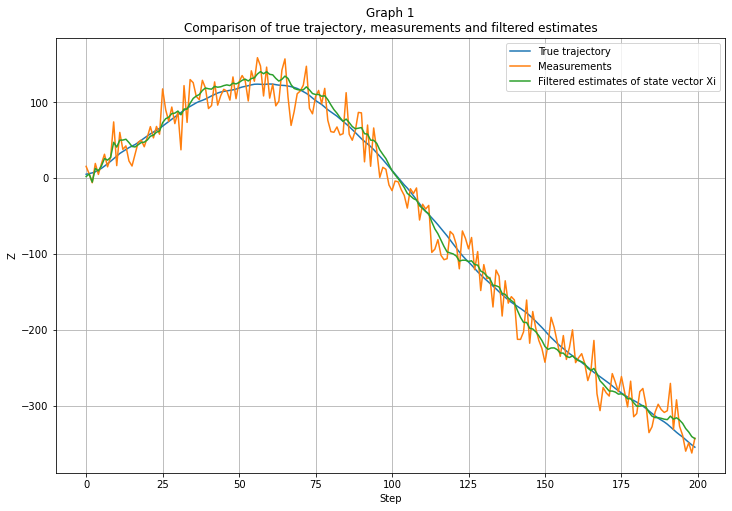

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(X[:,0])
plt.plot(z)
plt.plot(X_filt[:,0])
plt.grid()
plt.ylabel('Z')
plt.xlabel('Step')
plt.legend(['True trajectory', 'Measurements', 'Filtered estimates of state vector Xi'])
plt.title('Graph 1\nComparison of true trajectory, measurements and filtered estimates')

### As far as we can see from graph 1, Kalman filter works as an effective way to smooth noisy measurements.

#### Filter running several times

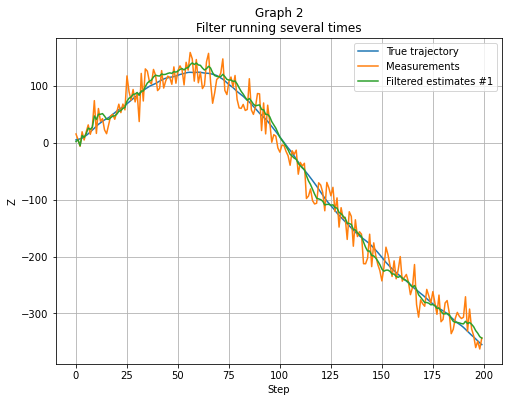

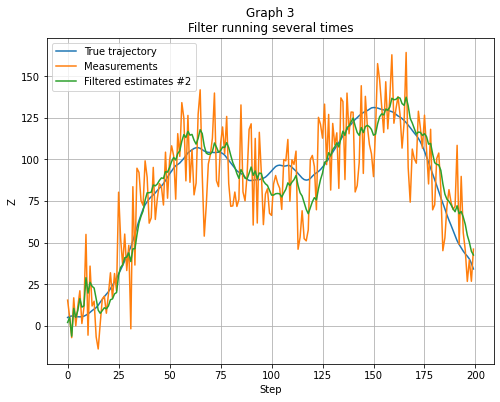

Text(0.5, 1.0, 'Graph 4\nFilter running several times')

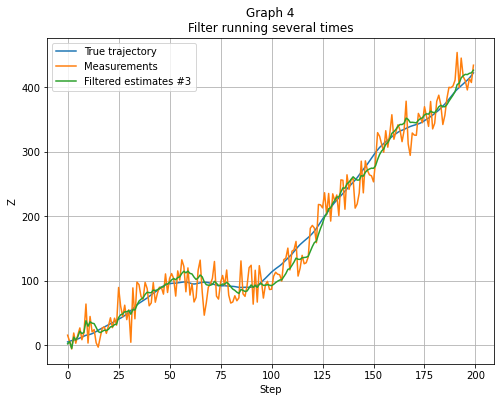

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(X[:, 0])
plt.plot(z)
plt.plot(X_filt[:,0])
plt.grid()
plt.ylabel('Z')
plt.xlabel('Step')
plt.legend(['True trajectory', 'Measurements', 'Filtered estimates #1','Filtered estimates #2',
            'Filtered estimates #3'])
plt.title('Graph 2\nFilter running several times')


plt.show()
plt.figure(figsize=(8, 6))
plt.plot(X1[:, 0])
plt.plot(z1)
plt.plot(X1_filt[:,0])
plt.grid()
plt.ylabel('Z')
plt.xlabel('Step')
plt.legend(['True trajectory', 'Measurements', 'Filtered estimates #2'])
plt.title('Graph 3\nFilter running several times')


plt.show()
plt.figure(figsize=(8, 6))
plt.plot(X2[:, 0])
plt.plot(z2)
plt.plot(X2_filt[:,0])
plt.grid()
plt.ylabel('Z')
plt.xlabel('Step')
plt.legend(['True trajectory', 'Measurements', 'Filtered estimates #3'])
plt.title('Graph 4\nFilter running several times')

### Graphs 2-4 show that Kalman filter works equally good for every kind of trajectories.

### 6. Plotting filter gain K

Gain stable = 0.13895150652807645
Standard deviation of estimation error stable = 7.455239943236608


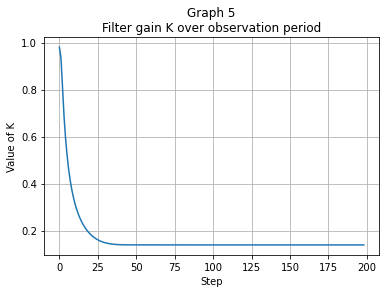

Text(0.5, 1.0, 'Graph 6\nStandard deviation of estimation error of coordinate xi')

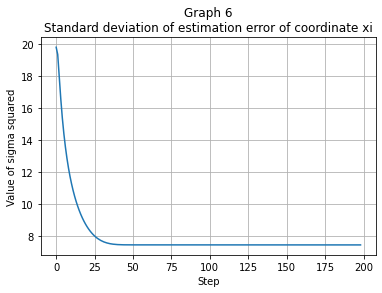

In [11]:
print("Gain stable =", K[125, 0])
print("Standard deviation of estimation error stable =", P[125, 0, 0] ** 0.5)
plt.plot(K[1:, 0])
plt.grid()
plt.ylabel('Value of K')
plt.xlabel('Step')
plt.title('Graph 5\nFilter gain K over observation period')


plt.show()
plt.plot(P[1:, 0, 0] ** 0.5)
plt.grid()
plt.ylabel('Value of sigma squared')
plt.xlabel('Step')
plt.title('Graph 6\nStandard deviation of estimation error of coordinate xi')

### From graph 5 and 6 we can see that filter gain K and filtration error covariance matrix become constant rather quickly. Steady state of K (after approxomately 30 steps) is optimal. It means that in conditions of a trajectory disturbed by random noise we cannot estimate more than established limit of accuracy due to uncertainty. 

### 7. Adding function of extrapolation

In [12]:
m = 7
X_extrapol = extrapol(X_filt, m, F)

Text(0.5, 1.0, 'Graph 7\nComparison of filtered and extrapolated filtered estimates')

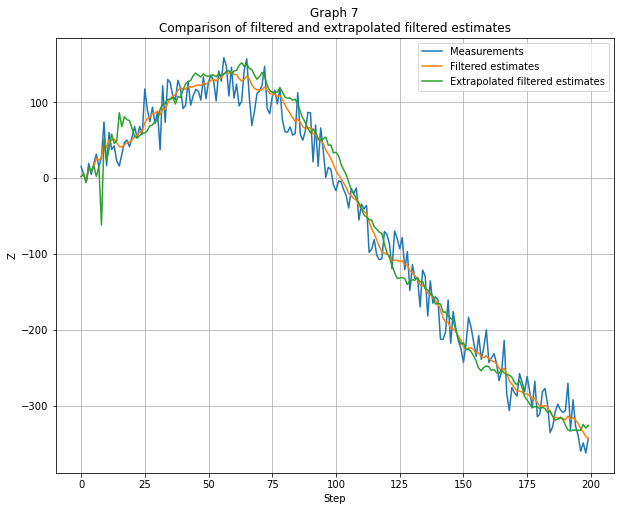

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(z)
plt.plot(X_filt[:, 0])
plt.plot(X_extrapol[:, 0])
plt.grid()
plt.ylabel('Z')
plt.xlabel('Step')
plt.legend(["Measurements","Filtered estimates", "Extrapolated filtered estimates"])
plt.title('Graph 7\nComparison of filtered and extrapolated filtered estimates')

### Graph 7 shows that extrapolated filtered estimates could be used to predict graph but they are not accurate. Therefore we can assume that applying only extrapolation for forecasting is not sufficient, even when used on almost smoothed data.   

### 8. Calculating  error of estimation 

In [14]:
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
P0 = np.array([[10000, 0], [0, 10000]])
P_res1 = np.zeros([500, 2, 2])
xf = np.zeros([200, 2])
kal_filt = kalman_filt(z, X0, P0, F, Q, R, H)
xf = kal_filt[0]
P_res1[0] = kal_filt[3]
for i in range(500):
    kal_filt = kalman_filt(xf[:, 0], X0, P0, F, Q, R, H)
    xf = kal_filt[0]
    P_res1[i] = kal_filt[3]
    X_extrapol = extrapol(xf, m, F)
    err1[i] = (X[3:, 0] - xf[3:, 0]) ** 2
    err2[i] = (X[3:, 0] - X_extrapol[3:, 0]) ** 2
final_err11 = np.zeros(500)
final_err12 = np.zeros(500)
for i in range(500):
    final_err11[i] = np.sqrt(np.mean(err1[i]))
    final_err12[i] = np.sqrt(np.mean(err2[i]))

Text(0.5, 1.0, 'Graph 8\nErrors after 500 runs')

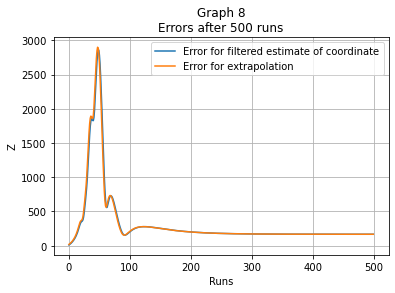

In [15]:
plt.plot(final_err11)
plt.plot(final_err12)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Runs')
plt.legend(["Error for filtered estimate of coordinate", "Error for extrapolation"])
plt.title('Graph 8\nErrors after 500 runs')

### After 500 runs errors for both Klaman filter and extrapolated results grow rapidly up to 8000 which is close to preassigned 10000 (first element of the P array), but then both stabilize and decrease almost to preassigned standard deviation = 20. At this moment filter becomes stationary and this constant filter gain can be used in the algorithm instead of calculating filter gain at every time step.  

### 9. Comparing mean-squared error of filtered estimate with standard deviation of measurement errors

In [16]:
print("Standard deviation of measurement errors =", np.std(x - z))
print("Mean-squared error of filtered estimate =", final_err11[0])

Standard deviation of measurement errors = 21.11709343815479
Mean-squared error of filtered estimate = 11.9528013923627


 ### Mean-squared error of filtered estimate and standard deviation of measurement errors are about the same order of magnitude, therefore we can assume that filtration is effective.

### 10. Filtration with more accurate initial filtration error covariance matrix

In [17]:
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
P0 = np.array([[100, 0], [0, 100]])
P_res2 = np.zeros([500, 2, 2])
xf = np.zeros([200, 2])
kal_filt = kalman_filt(z, X0, P0, F, Q, R, H)
xf = kal_filt[0]
P_res2[0] = kal_filt[3]
for i in range(500):
    kal_filt = kalman_filt(xf[:, 0], X0, P0, F, Q, R, H)
    xf = kal_filt[0]
    P_res2[i] = kal_filt[3]
    X_extrapol = extrapol(xf, m, F)
    err1[i] = (X[3:, 0] - xf[3:, 0]) ** 2
    err2[i] = (X[3:, 0] - X_extrapol[3:, 0]) ** 2
final_err21 = np.zeros(500)
final_err22 = np.zeros(500)
for i in range(500):
    final_err21[i] = np.sqrt(np.mean(err1[i]))
    final_err22[i] = np.sqrt(np.mean(err2[i]))

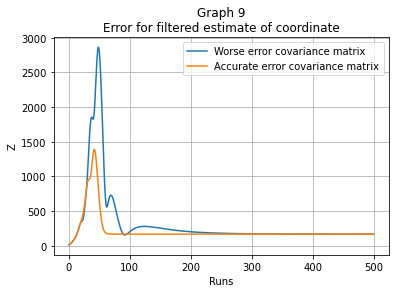

Text(0.5, 1.0, 'Graph 10\nError for extrapolation')

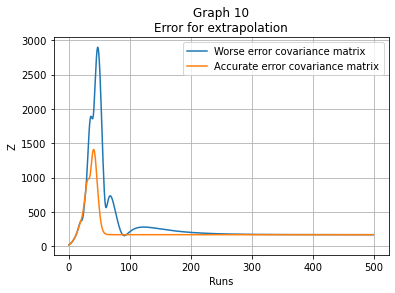

In [18]:
plt.plot(final_err11)
plt.plot(final_err21)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Runs')
plt.legend(["Worse error covariance matrix", "Accurate error covariance matrix"])
plt.title('Graph 9\nError for filtered estimate of coordinate')
plt.show()
plt.plot(final_err12)
plt.plot(final_err22)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Runs')
plt.legend(["Worse error covariance matrix", "Accurate error covariance matrix"])
plt.title('Graph 10\nError for extrapolation')

### Graphs 9 and 10 show that with more accurate error covariance matrix we get steady result for K way faster. Also we can see that choice of initial conditions doesn’t affect the estimation results after approximately 200 steps. 

### 11. Comparing calculation errors of estimation Pi,i provided by Kalman filter algorithm with true estimation errors

Text(0.5, 1.0, 'Graph 11\nComparison of estimation errors')

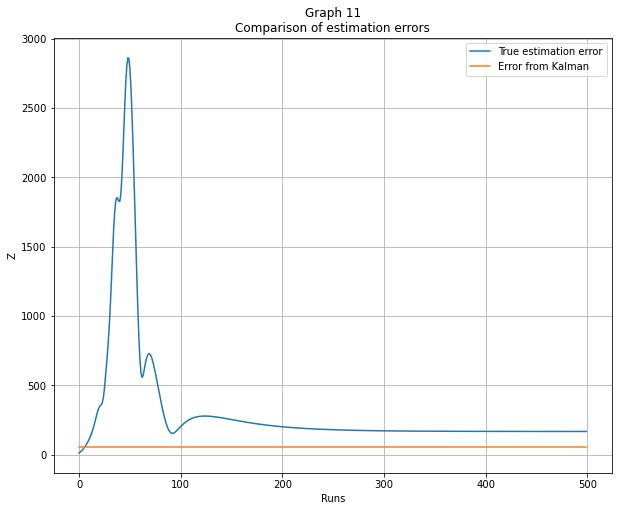

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(final_err11)
plt.plot(P_res1[:, 0, 0])
plt.grid()
plt.ylabel('Z')
plt.xlabel('Runs')
plt.legend(["True estimation error", "Error from Kalman"])
plt.title('Graph 11\nComparison of estimation errors')

### Graph 11 shows that calculation errors of estimation do not correspond to true estimation errors, especially on first 100 steps due to big values from filtration error covariance matrix. After 100 steps both calculation errors and errors provided by Kalman filter algorithm stabilize, but are still approximately 10 times different. That means that we have to keep in mind that we could be futher from real trajectory.

### 12. Running filter for deterministic trajectory

In [20]:
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
sigmaa_2 = 0
v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a, v)
Q = np.dot(np.dot(G, G.transpose()), sigmaa_2)
P0 = np.array([[0, 0], [0, 0]])
X = np.zeros([200, 2])
X[0] = np.array([x[0], v[0]])
for i in range(1, len(X)):
    X[i] = np.dot(F, X[i - 1]) + np.dot(G, a[i - 1])
P_res = np.zeros([500, 2, 2])
K_res = np.zeros([500, 2])
kal_filt = kalman_filt(x, X[0], P0, F, Q, R, H)
xf = kal_filt[0]
P_res[0] = kal_filt[3]
K_res[0] = kal_filt[4]
for i in range(500):
    kal_filt = kalman_filt(xf, X[0], P0, F, Q, R, H)
    xf = kal_filt[0]
    P_res[i] = kal_filt[3]
    K_res[i] = kal_filt[4]
    X_extrapol = extrapol(xf, m, F)
    err1[i] = (xf[3:, 0] - x[3:]) ** 2
    err2[i] = (x[3:] - X_extrapol[3:, 0]) ** 2
final_err31 = np.zeros(500)
final_err32 = np.zeros(500)
for i in range(500):
    final_err31[i] = np.sqrt(np.mean(err1[i]))
    final_err32[i] = np.sqrt(np.mean(err2[i]))

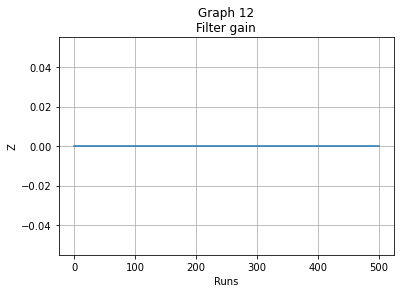

Text(0.5, 1.0, 'Graph 13\nEstimation and calculation errors')

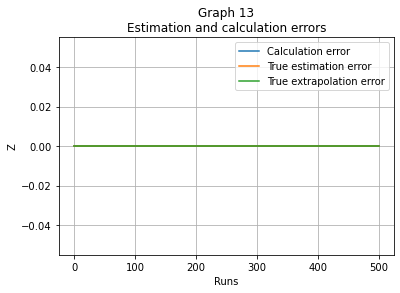

In [21]:
plt.plot(K_res[:, 0])
plt.grid()
plt.ylabel('Z')
plt.xlabel('Runs')
plt.title('Graph 12\nFilter gain')
plt.show()
plt.plot(P_res[:, 0, 0] ** 0.5)
plt.plot(final_err31)
plt.plot(final_err32)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Runs')
plt.legend(["Calculation error", "True estimation error", "True extrapolation error"])
plt.title('Graph 13\nEstimation and calculation errors')

### Graphs above show that in conditions of motion without any random disturbances, estimation error approaches to zero and filter switches off from measurements (new measurements almost do not adjust estimates). 

### 13. Using deterministic model on motion disturbed by random acceleration

In [22]:
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
sigmaa_2 = 0.2 ** 2
v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a, v)
Q = 0
P0 = np.array([[10000, 0], [0, 10000]])
X = np.zeros([200, 2])
X[0] = np.array([x[0], v[0]])

P_res = np.zeros([500, 2, 2])
K_res = np.zeros([500, 2])
kal_filt = kalman_filt(x, X[0], P0, F, Q, R, H)
xf = kal_filt[0]
P_res[0] = kal_filt[3]
K_res[0] = kal_filt[4]
for i in range(500):
    kal_filt = kalman_filt(xf, X[0], P0, F, Q, R, H)
    xf = kal_filt[0]
    P_res[i] = kal_filt[3]
    K_res[i] = kal_filt[4]
    X_extrapol = extrapol(xf, m, F)
    err1[i] = (xf[3:, 0] - x[3:]) ** 2
    err2[i] = (x[3:] - X_extrapol[3:, 0]) ** 2
final_err41 = np.zeros(500)
final_err42 = np.zeros(500)
for i in range(500):
    final_err41[i] = np.sqrt(np.mean(err1[i]))
    final_err42[i] = np.sqrt(np.mean(err2[i]))

Calculation errors of estimation = 2.824585690243437
True estimation errors = 0.2


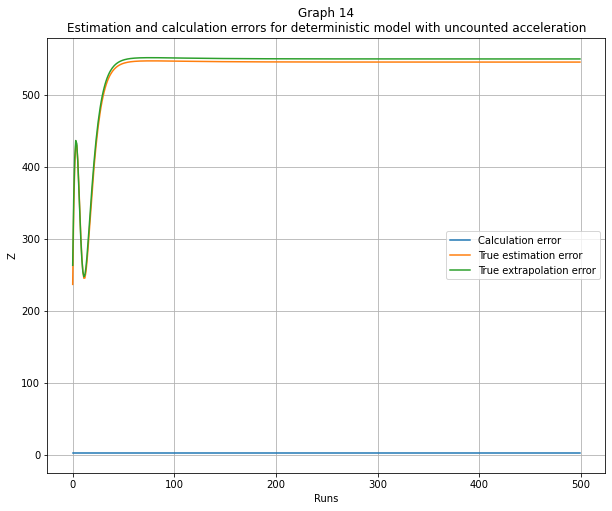

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(P_res[:, 0, 0] ** 0.5)
plt.plot(final_err41)
plt.plot(final_err42)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Runs')
plt.legend(["Calculation error", "True estimation error", "True extrapolation error"])
plt.title('Graph 14\nEstimation and calculation errors for deterministic model with uncounted acceleration')
print("Calculation errors of estimation =", P_res[0, 0, 0] ** 0.5)
print("True estimation errors =", sigmaa_2 ** 0.5)

### On the graph above we can see drastic difference between calculated and true errors due to the lack of covariance matrix Q in calculations. So that means that calculations from Kalman filter do not reflect the real situation and filter itself works incorrect. The nature of the noise must be taken into account in order to avoid situation like this.

### 14.  Analyzing relationship between state and measurement noise

In [24]:
sigmaa1_2 = 0.2 ** 2
v1,a1 = gnerate_vel_and_ac(0, sigmaa1_2 ** 0.5, T, v0, numb)
x1 = generate_x(T, x0, a1, v1)

sigmaa2_2 = 1 ** 2
v2,a2 = gnerate_vel_and_ac(0, sigmaa2_2 ** 0.5, T, v0, numb)
x2 = generate_x(T, x0, a2, v2)

X0 = np.array([5, 1])

Q1 = np.dot(np.dot(G, G.transpose()), sigmaa1_2)
Q2 = np.dot(np.dot(G, G.transpose()), sigmaa2_2)

eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
z1 = x1 + eta
z2 = x2 + eta

X_filt1, P1, K1 = kalman_filt(z1, X0, P0, F, Q1, R, H)[:3]
X_filt2, P2, K2 = kalman_filt(z2, X0, P0, F, Q2, R, H)[:3]

Text(0.5, 1.0, 'Graph 15\nComparison of K')

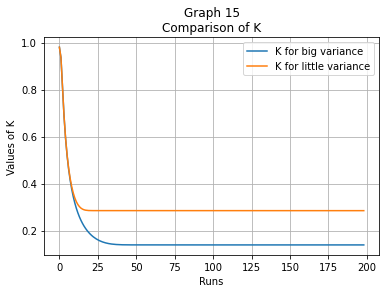

In [25]:
plt.plot(K1[1:,0])
plt.plot(K2[1:,0])
plt.grid()
plt.ylabel('Values of K')
plt.xlabel('Runs')
plt.legend(["K for big variance", "K for little variance"])
plt.title('Graph 15\nComparison of K')

### From graph 15 we can assume that the greater variance is, the faster K becomes stable and its' value is bigger then for the one with less variance. 

### 15. Analyzing sensitivity of filter to underestimated non-optimal filter gain K

In [26]:
sigmaa_2 = 0.2 ** 2
v,a = gnerate_vel_and_ac(0, sigmaa1_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a1, v1)
Q = np.dot(np.dot(G, G.transpose()), sigmaa_2)

X0 = np.array([100, 5])
P0 = np.array([[100, 0], [0, 100]])

xf = np.zeros([200, 2])
kal_filt = kalman_filt(x, X0, P0, F, Q, R, H)
K = kal_filt[2]
xf = kal_filt[0]
P_res[0] = kal_filt[3]
K_res[0] = kal_filt[4]
for i in range(500):
    kal_filt = kalman_filt(xf[:, 0], X0, P0, F, Q, R, H)
    xf = kal_filt[0]
    P_res[i] = kal_filt[3]
    K_res[i] = kal_filt[4]
    X_extrapol = extrapol(xf, m, F)
    err1[i] = (X[3:, 0] - xf[3:, 0]) ** 2
    err2[i] = (X[3:, 0] - X_extrapol[3:, 0]) ** 2
final_err51 = np.zeros(500)
final_err52 = np.zeros(500)
for i in range(500):
    final_err51[i] = np.sqrt(np.mean(err1[i]))
    final_err52[i] = np.sqrt(np.mean(err2[i]))

Gain stable = 0.1389515046281197


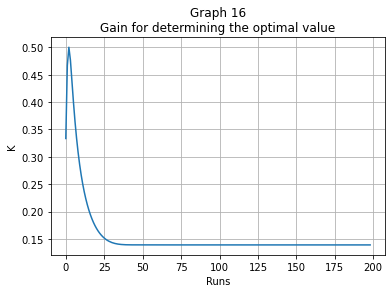

Text(0.5, 1.0, 'Graph 17\nTrue errors')

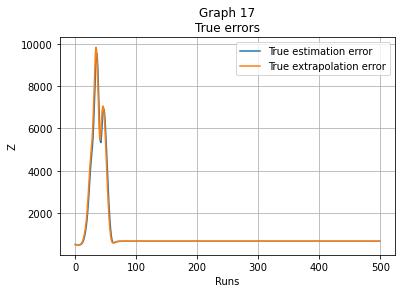

In [27]:
print("Gain stable =", K[125, 0])
K_fix = K[125, 0] / 5
plt.plot(K[1:, 0])
plt.grid()
plt.ylabel('K')
plt.xlabel('Runs')
plt.title('Graph 16\nGain for determining the optimal value')
plt.show()
plt.plot(final_err51)
plt.plot(final_err52)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Runs')
plt.legend(["True estimation error", "True extrapolation error"])
plt.title('Graph 17\nTrue errors')

In [28]:
sigmaa_2 = 0.2 ** 2
v,a = gnerate_vel_and_ac(0, sigmaa1_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a1, v1)
Q = np.dot(np.dot(G, G.transpose()), sigmaa_2)

X0 = np.array([100, 5])
P0 = np.array([[100, 0], [0, 100]])

xf = np.zeros([200, 2])
kal_filt = kalman_filt_fix_K(x, X0, P0, F, Q, R, H, K_fix)
xf = kal_filt[0]
P_res[0] = kal_filt[3]
K_res[0] = kal_filt[4]
for i in range(500):
    kal_filt = kalman_filt_fix_K(xf[:, 0], X0, P0, F, Q, R, H, K_fix)
    xf = kal_filt[0]
    P_res[i] = kal_filt[3]
    K_res[i] = kal_filt[4]
    X_extrapol = extrapol(xf, m, F)
    err1[i] = (X[3:, 0] - xf[3:, 0]) ** 2
    err2[i] = (X[3:, 0] - X_extrapol[3:, 0]) ** 2
final_err61 = np.zeros(500)
final_err62 = np.zeros(500)
for i in range(500):
    final_err61[i] = np.sqrt(np.mean(err1[i]))
    final_err62[i] = np.sqrt(np.mean(err2[i]))

Text(0.5, 1.0, 'Graph 18\nEstimation and calculation errors\nfor non-optimal filter gain K')

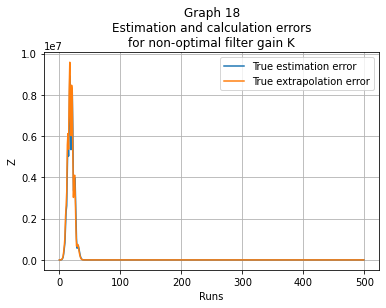

In [29]:
plt.plot(final_err61)
plt.plot(final_err62)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Runs')
plt.legend(["True estimation error", "True extrapolation error"])
plt.title('Graph 18\nEstimation and calculation errors\nfor non-optimal filter gain K')

### Graph 18 shows great difference between estimation and extrapolation errors calculated with optimal K (graph 17). Hence the conclusion that such parametr as filter gain K in Kalman filter is of great importance and should be calculated neatly. 

## Learning log
### Initialization of functions and realisation of Kalman filter was made by Vladimir Berman. According to graphs 2-4, Kalman filter works equally effective on various types of trajectories.
### Artem Bazhenov was dealing with extrapolation realization. Applying only it even on almost smoothed data for for forecasting seems to be not sufficient. 
### Comparison of filtration with different start filtration error covariance matrix was made by Maria Dronova. It shows that the closer first estimation of P to reality, the faster we get steady result of filter gain K. 
### Comparing calculation errors of estimation Pi,i provided by Kalman filter algorithm with true estimation errors was carried out by Vladimir. It shows that estimation Pi,i from Kalman filter differ rather significant from true estimation errors, especially on first 100 steps.
### Running filter for deterministic trajectory and deterministic trajectory with uncounted accleration was Maria's task. First process shows that gain K tends to 0 in all the runs, as well as all the errors. The situation with uncounted noise is different: calculation error is almost 0 but true errors at the same time are far from it. Hence the conclusion that the initial evaluation of the process should be carried out carefully. 
### Analysis of sensitivity of filter to underestimated non-optimal filter gain K was made by Artem. The result shows that K has a big impact on the filtrarion process.
### Conclusions were made together after group discussion, then report was made by Maria. 